In [1]:
%matplotlib inline
import random
import json
import math
import geopandas as gpd

In [2]:
# 都道府県コード読み込み
with open("id.json") as f:
    j = json.load(f)
pref2int = j["japanmap_pref_reverse"]
int2pref = j["japanmap_pref_code"]

In [3]:
# 隣接都道府県リスト読み込み
neighbor = {}
with open("neighbor_jp.txt") as f:
    for line in f:
        li = line.strip().split()
        neighbor[pref2int[li[0]]] = [pref2int[e] for e in li[1:]]

In [4]:
# Qはdict使ってるが。配列っぽく表示。
def print_arr(a, n):
    print("\n".join(" ".join("%4.1f" % a.get((i, j), 0.0) for j in range(n)) for i in range(n)))

In [5]:
# 都道府県数 * 色数
N = 47 * 4

In [6]:
# QUBOマトリックス。
# N*Nの行列だが、どうせスパースなのでdictにする。
Q = {}

In [7]:
# 各都道府県は、1色だけに塗られる(色なしや、複数色にはしない)という制約
for pr in range(47):
    for c1 in range(4):
        Q[pr*4 + c1, pr*4 + c1] = -1.0
        for c2 in range(c1+1, 4):
            Q[pr*4 + c1, pr*4+c2] = 2.0

In [8]:
# 隣接する都道府県は、違う色に塗られる、という制約
for k, ne in neighbor.items():
    k -= 1
    for kk in (x-1 for x in ne):
        if k > kk:
            continue
        for c in range(4):
            Q[k*4 + c, kk*4 + c] = 1.0

In [9]:
# QUBOマトリックスをJijとhiに変換。
h = [-sum(Q.get((i, k), 0.0) + Q.get((k, i), 0.0) for k in range(N)) for i in range(N)]
J = {k: -v for k,v in Q.items() if k[0] < k[1]}

In [18]:
s = [random.choice((-1.0, 1.0)) for _ in range(N)]
kt = 5.0
e = -sum(J[i,j] * s[i] * s[j] for i,j in J) - sum(h_ * s_ for h_, s_ in zip(h, s))
for _ in range(10000):
    # ひっくり返すスピンを選択
    t = random.randrange(N)
    # うまくdEだけを求める方法が分からなかったので、とりあえずひっくり返してエネルギー求め直す。
    # 採用なら、エネルギーを求め直した値に更新し、不採用ならひっくり返したスピンを戻す。
    s[t] = -s[t]
    e_ = -sum(J[i,j] * s[i] * s[j] for i,j in J) - sum(h_ * s_ for h_, s_ in zip(h, s))
    if e_ < e or math.exp((e-e_)/kt) > random.random():
        e = e_
    else:
        s[t] = -s[t]
    kt *= 0.99

In [19]:
def argmax(it):
    return max(enumerate(it), key=lambda x:x[1])[0]

In [20]:
# 都道府県ごとの色番号をとる。
it = iter(s)
ans = []
for i in range(47):
    ans.append(argmax((next(it), next(it), next(it), next(it))))

In [21]:
# 色番号ごとの都道府県に並べ替える。
ans2 = [[] for _ in range(4)]
for i,c in enumerate(ans):
    ans2[c].append(i)

In [22]:
df = gpd.read_file("japan.geojson")

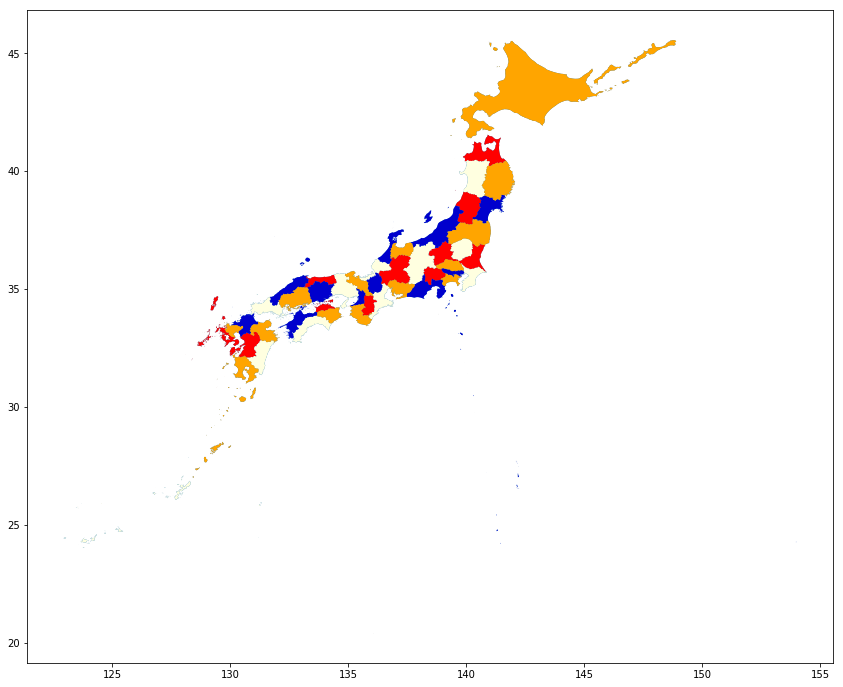

In [23]:
ax = df.plot(figsize=(15,12))
gpd.GeoDataFrame(df, index=ans2[0]).plot(ax=ax, color='red')
gpd.GeoDataFrame(df, index=ans2[1]).plot(ax=ax, color='lightyellow')
gpd.GeoDataFrame(df, index=ans2[2]).plot(ax=ax, color='mediumblue')
gpd.GeoDataFrame(df, index=ans2[3]).plot(ax=ax, color='orange')